(0.0, 10.705946771299573)

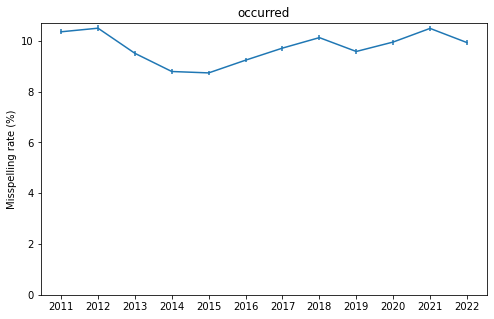

In [4]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import default_rng
from matplotlib import pyplot as plt

rng = default_rng()
def beta_ci(alpha, beta, width=95, samples=10000):
    """Stochastically estimate a width% confidence interval for the mean of a beta
    distribution with the given values of alpha and beta, taking the given number of samples.
    """
    mus = rng.beta(alpha, beta, samples)
    bookend = (100 - width)/2
    ciles = [bookend, 100-bookend]
    return np.percentile(mus, ciles)

class PatternCounts(object):
    
    def __init__(self, name, alts, counts):
        self.name = name
        self.alts = alts
        self.counts = counts
        
    @property
    def xvals(self):
        return list(self.counts[self.name].keys())
    
    def yvals(self, normalized, nomain=False, combine=False):
        raw = np.array([ list(subcounts.values()) for subcounts in self.counts.values() ])
        res = raw
        if normalized:
            # Normalize so that columns sum to 100
            normed = 100 * raw / raw.sum(axis=0)
            res = normed
        if nomain:
            res = res[1:]
        if combine:
            res = res.sum(axis=0)
        return res
    
    @property
    def labels(self):
        return list(self.counts.keys())
    
    def errors(self, ci=95):
        counts = self.yvals(normalized=False, nomain=False)
        betas = counts[0]
        alphas = counts[1:].sum(axis=0)
        errs = []
        for i in range(len(alphas)):
            e = beta_ci(alphas[i], betas[i], ci)
            errs.append(e)
        # Reshape from (n, 2) to (2, n)
        return np.array(errs).T
    
    @classmethod
    def from_json(cls, dat):
        main = None
        alts = []
        counts = {}
        for datum in dat:
            patt = datum['pattern']
            if datum['type'] == 'main':
                main = patt
            else:
                alts.append(patt)
            counts[patt] = datum['counts']
        return cls(main, alts, counts)
        

DATA_DIR = 'data'
def load_counts():
    res = {}
    for fname in os.listdir(DATA_DIR):
        if not fname.endswith('.json'):
            continue
        path = os.path.join(DATA_DIR, fname)
        with open(path) as f:
            dat = json.load(f)
        pc = PatternCounts.from_json(dat)
        res[pc.name] = pc
    return res

FS = (6, 4)
def pc_area(pc, ax=None,
            normalized=True,
            figsize=FS,
           ):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.stackplot(
        pc.xvals,
        pc.yvals(normalized),
        labels=pc.labels,
    )
    return ax

def pc_just_misspellings(pc,
                         ax=None,
                         figsize=FS,
                        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.stackplot(
        pc.xvals,
        pc.yvals(normalized=True, nomain=True),
        labels=pc.labels[1:],
    )
    ax.set_ylabel("% of all attempts")
    ax.set_title(pc.name)
    return ax

def eb(pc,
       ax,
       ci=95,
      ):
    x = pc.xvals
    y = pc.yvals(normalized=True, nomain=True, combine=True)
    yerr = pc.errors(ci)
    ax.errorbar(x, y, yerr)
    ax.set_title(pc.name)
    ax.set_ylabel("Misspelling rate (%)")


d = load_counts()
lb = d['lightning bolt']
lb = d['occurred']
fig, ax = plt.subplots(figsize=(8,5))
eb(lb, ax)
ax.set_ylim(0)
#pc_area(lb, ax)
#pc_just_misspellings(lb, ax)
#ax.legend();

In [37]:
def to_df(d):
    rows = []
    for cluster in d.values():
        pcts = cluster.yvals(normalized=True, nomain=True, combine=True)
        years = cluster.xvals
        for year, pct in zip(years, pcts):
            row = dict(year=int(year), err=pct, word=cluster.name)
            rows.append(row)
    return pd.DataFrame(rows)

df = to_df(d)

In [36]:
df.head()

,year,err,word
0,2011,1.292051,environment
1,2012,1.636906,environment
2,2013,1.574450,environment
3,2014,1.592892,environment
4,2015,1.623638,environment


In [51]:
by_avg_err = df.groupby('word')['err'].mean().sort_values(ascending=False)
by_avg_err.head(5)

word
have led to    26.988220
take a peek    21.943597
liaison        18.978769
accommodate    11.378362
caribbean      10.431496
Name: err, dtype: float64

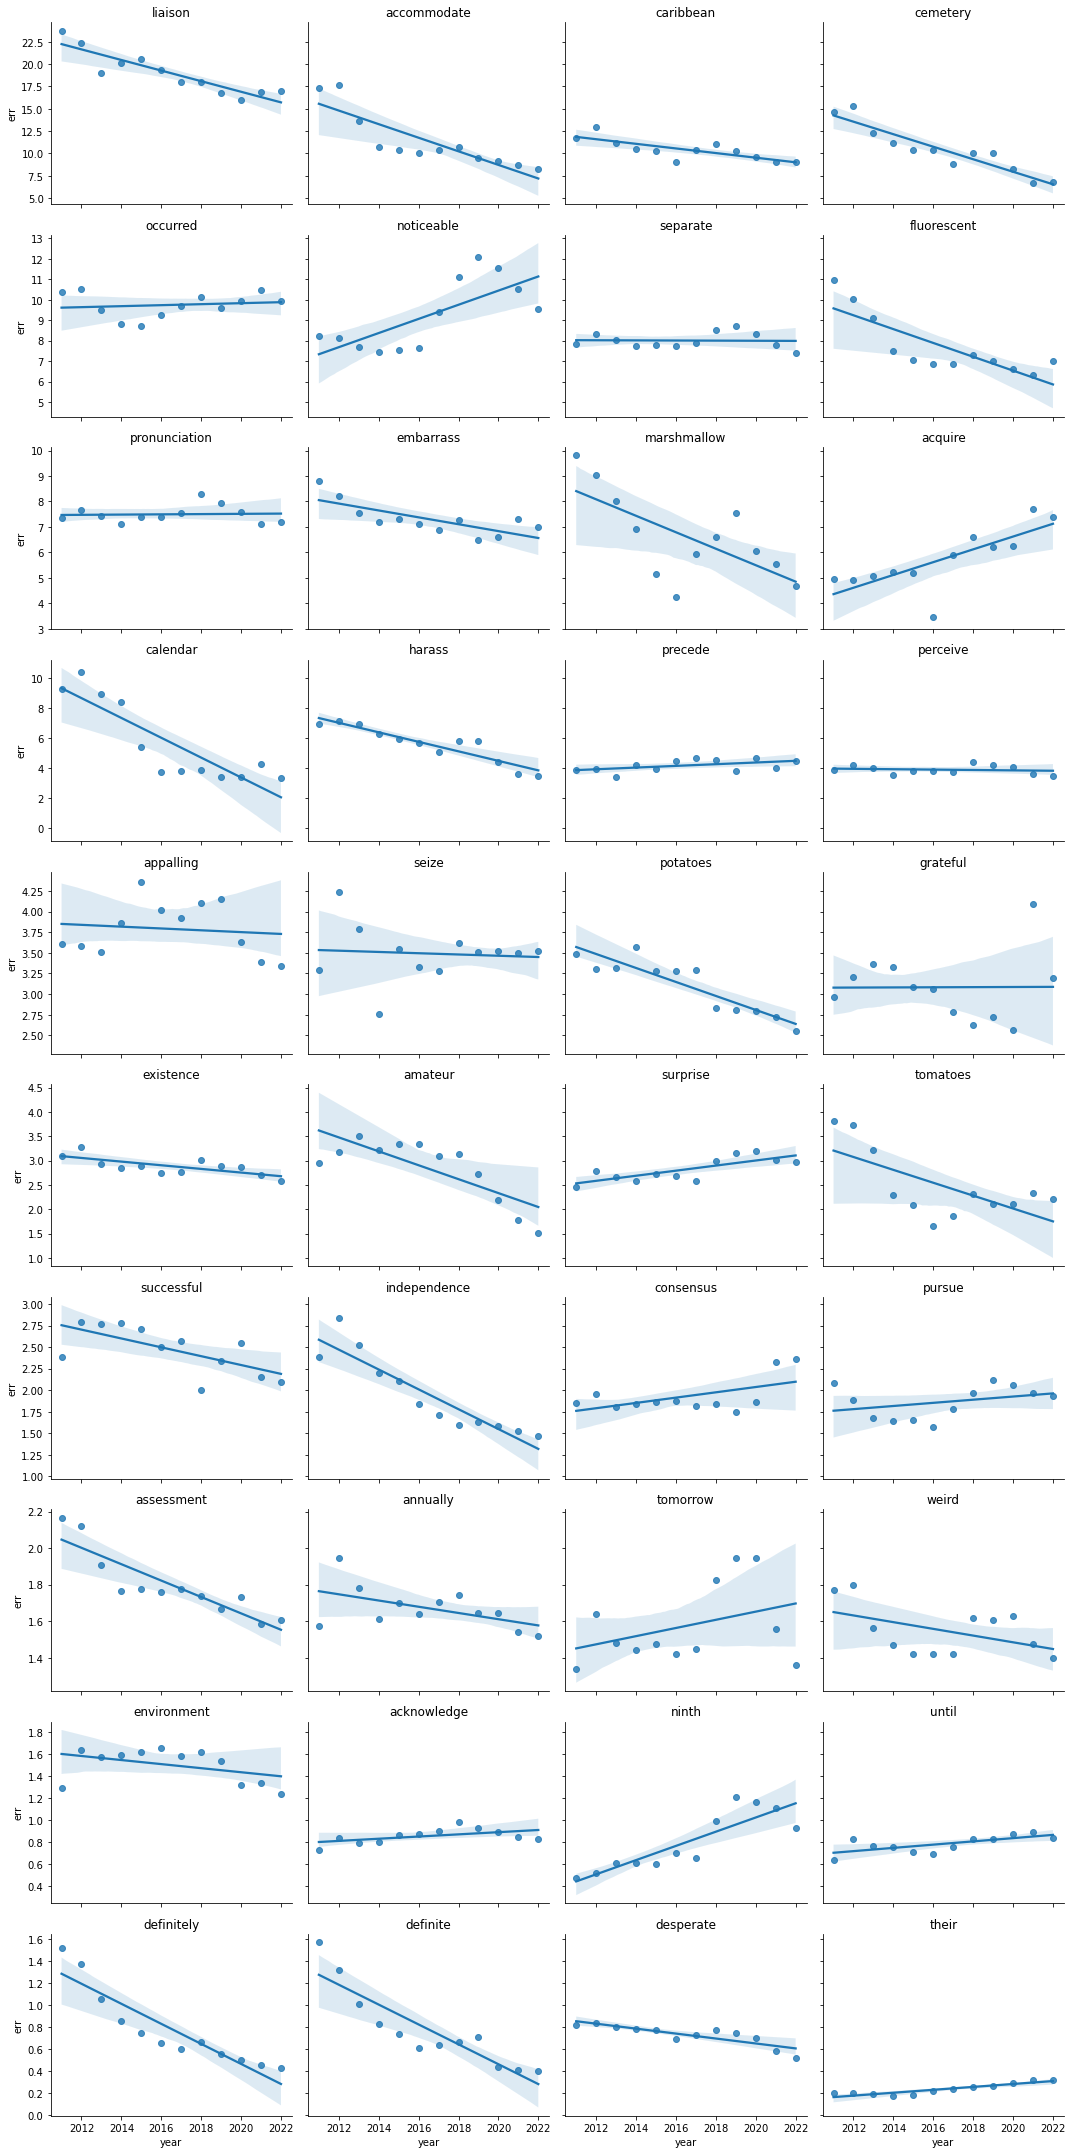

In [67]:
blacklist = {'necessary',
             'lightning bolt',
             'have led to',
             'take a peek',
             'big effect',
            }
n = 40
words = by_avg_err[~by_avg_err.index.isin(blacklist)].head(n).index
sub_df = df[df.word.isin(words)]

def dummify(df, words):
    res = df.copy()
    cols = 4
    res['row'] = -1
    res['col'] = -1
    for i, word in enumerate(words):
        row = i // cols
        col = i % cols
        res.loc[res.word == word, 'row'] = row
        res.loc[res.word == word, 'col'] = col
    return res

ddf = dummify(sub_df, words)
    

foo = sns.lmplot(x='year', y='err',
                 col='col',
                 row='row',
                 data=ddf,
           #col_order=words,
           #col_wrap=4,
           aspect=1.25,
           height=3,
           facet_kws={
               'sharey': 'row',
           },
          );

for i, ax in enumerate(foo.axes.flatten()):
    title = words[i]
    ax.set_title(title)

In [64]:
foo.axes

array([[<AxesSubplot:title={'center':'row = 0 | col = 0'}, ylabel='err'>,
        <AxesSubplot:title={'center':'row = 0 | col = 1'}>,
        <AxesSubplot:title={'center':'row = 0 | col = 2'}>,
        <AxesSubplot:title={'center':'row = 0 | col = 3'}>],
       [<AxesSubplot:title={'center':'row = 1 | col = 0'}, ylabel='err'>,
        <AxesSubplot:title={'center':'row = 1 | col = 1'}>,
        <AxesSubplot:title={'center':'row = 1 | col = 2'}>,
        <AxesSubplot:title={'center':'row = 1 | col = 3'}>],
       [<AxesSubplot:title={'center':'row = 2 | col = 0'}, ylabel='err'>,
        <AxesSubplot:title={'center':'row = 2 | col = 1'}>,
        <AxesSubplot:title={'center':'row = 2 | col = 2'}>,
        <AxesSubplot:title={'center':'row = 2 | col = 3'}>],
       [<AxesSubplot:title={'center':'row = 3 | col = 0'}, xlabel='year', ylabel='err'>,
        <AxesSubplot:title={'center':'row = 3 | col = 1'}, xlabel='year'>,
        <AxesSubplot:title={'center':'row = 3 | col = 2'}, xlabel='year

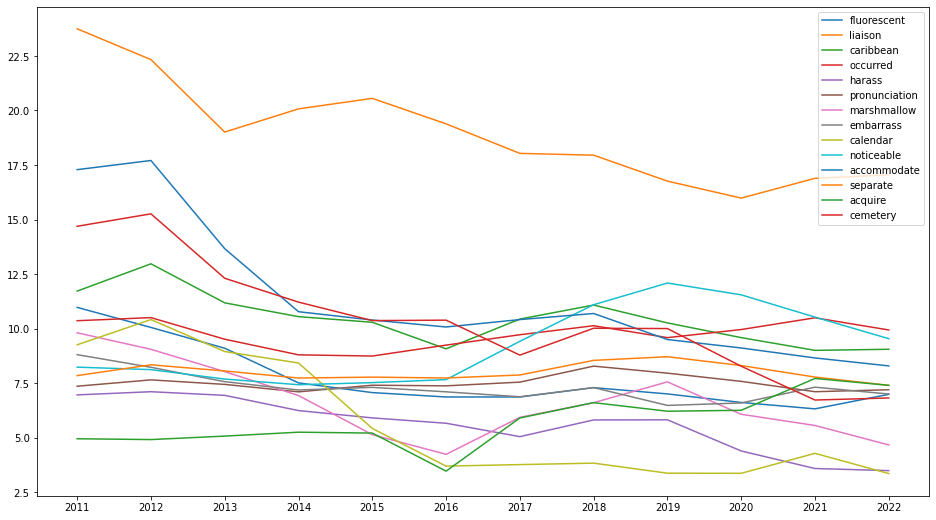

In [27]:
FS = (16, 9)
fig, ax = plt.subplots(figsize=FS)

blacklist = {'necessary',
             'their',
             'ignorance',
             'lightning bolt',
             'have led to',
             'take a peek',
             'big effect',
             
             'desparate',
             'ninth',
             'acknowledge',
            }
ythresh = 5
eg = d['acquire']
labels = list(d.keys())
x = eg.xvals
ys = [cluster.yvals(normalized=True, nomain=True, combine=True) for cluster in d.values()]
for i in range(len(d)):
    label = labels[i]
    y = ys[i]
    if label in blacklist:
        continue
    if max(y) < ythresh:
        continue
    ax.plot(x,
            y,
            label=label,
           )
ax.legend();

In [3]:
figdir = 'figs'
FS = (8, 5)
plot_fn = eb
for name, pc in d.items():
    fig, ax = plt.subplots(figsize=FS)
    #pc_area(pc, ax=ax)
    plot_fn(pc, ax)
    if len(pc.alts) > 1 and 0:
        ax.legend(loc='lower left')
    ax.set_ylim(0)
    #ax.set_title(f'Misspellings of "{pc.name}" over time on Reddit')
    ax.set_title(f'"{pc.name}" misspellings ({pc.alts})')
    fname = os.path.join(figdir, name.replace(' ', '_') + '.png')
    fig.set_facecolor('white')
    fig.savefig(fname, dpi=120)
    fig.clf()

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>